# ChIP-seq Genomic Range Annotation Tutorial

In [135]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import genomic_features as gf

# Data retrieval
import pooch
import bioframe
import seaborn
import matplotlib.pyplot as plt

## Download example data

The data used in this tutorial is ChIP-seq IDR ranked peaks with target CTCF, downloaded from ENCODE (accession: ENCFF417KHZ). The data is from CRISPR modified Homo Sapien cell line HCT116 and more information about the dataset can be found on the ENCODE website [here](https://www.encodeproject.org/experiments/ENCSR385CDF/). Column names are assigned by bioframe using the function read_table() based on the column contents.

In [2]:
ctcf_peak = bioframe.read_table(
    "https://www.encodeproject.org/files/ENCFF417KHZ/@@download/ENCFF417KHZ.bed.gz",
    schema="narrowPeak"
)
ctcf_peak

/Users/vmuckerson/.venv/lib/python3.12/site-packages/bioframe/io/fileops.py:74: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath_or, **kwargs)


,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr10,99392395,99392827,.,1000,.,306.78095,-1.0,4.96085,230
1,chr3,194929204,194929707,.,1000,.,284.09197,-1.0,4.96085,234
2,chr8,97559907,97560401,.,1000,.,284.16880,-1.0,4.96085,242
3,chr8,66609310,66609747,.,1000,.,265.66492,-1.0,4.96085,238
4,chr15,66903598,66904095,.,1000,.,263.27660,-1.0,4.96085,252
...,...,...,...,...,...,...,...,...,...,...
129238,chr17,55794221,55794717,.,78,.,5.91739,-1.0,0.35122,248
129239,chr5,39135451,39135947,.,78,.,6.62387,-1.0,0.51343,248
129240,chr20,16241885,16242381,.,78,.,8.24784,-1.0,0.96486,248
129241,chr2,39231186,39231682,.,78,.,6.21278,-1.0,0.42335,248


## Download Ensembl annotations using genomic_features

Using the genomic ranges provided in the bed file's chromosome, start, and end columns we can asscribe an ensembl gene id from EnsemblDB to each peak. Read in the correct ensembl annotation version to match to the data.

In [3]:
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
ensdb.list_columns()  #you can custom select the columns output if exon, protein, or sequence information that is not included by default

genes = ensdb.genes(    
    filter=gf.filters.GeneBioTypeFilter("protein_coding"),
    #cols=["gene_id", "gene_name","gene_biotype", "gene_seq_start",
    #      "gene_seq_end","seq_name","seq_strand","exon_id",
    #      "exon_seq_start","exon_seq_end"]
)
genes

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,ENSG00000000003,TSPAN6,protein_coding,100627108,100639991,X,-1,chromosome,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],ENSG00000000003.15,ENST00000373020
1,ENSG00000000005,TNMD,protein_coding,100584936,100599885,X,1,chromosome,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],ENSG00000000005.6,ENST00000373031
2,ENSG00000000419,DPM1,protein_coding,50934867,50959140,20,-1,chromosome,dolichyl-phosphate mannosyltransferase subunit...,ENSG00000000419.14,ENST00000371588
3,ENSG00000000457,SCYL3,protein_coding,169849631,169894267,1,-1,chromosome,SCY1 like pseudokinase 3 [Source:HGNC Symbol;A...,ENSG00000000457.14,ENST00000367771
4,ENSG00000000460,C1orf112,protein_coding,169662007,169854080,1,1,chromosome,chromosome 1 open reading frame 112 [Source:HG...,ENSG00000000460.17,ENST00000359326
...,...,...,...,...,...,...,...,...,...,...,...
22890,ENSG00000290318,,protein_coding,49357176,49412051,3,-1,chromosome,novel protein,ENSG00000290318.1,ENST00000704381
22891,ENSG00000290320,H2BN1,protein_coding,32895433,32906586,17,1,chromosome,H2B.N variant histone 1 [Source:HGNC Symbol;Ac...,ENSG00000290320.1,ENST00000704639
22892,ENSG00000291237,SOD2,protein_coding,159669069,159762529,6,-1,chromosome,superoxide dismutase 2 [Source:HGNC Symbol;Acc...,ENSG00000291237.1,ENST00000538183
22893,ENSG00000291239,,protein_coding,36850858,36998682,19,1,chromosome,novel protein,ENSG00000291239.1,ENST00000706165


## Mapping chromosome annotation styles

In order to annotate the ranges in the dataframe with gene symbols, ensembl ids, strand direction, etc. the two need to dataframes need to merge. To make this seemless we use the bioframe hg.38.alias_dict() to map the numeric Ensembl chromosome annotation with the "chr" notation of the CHIP-Seq dataset and remove any peaks with unmapped chromosome values. This step is optional but makes joining the two dataframes much simpler in the next step.

In [4]:
from bioframe import assembly_info

hg38 = assembly_info("hg38")

In [5]:
genes["seq_name"] = genes["seq_name"].map(hg38.alias_dict)
genes = genes.dropna(subset="seq_name")
genes

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,ENSG00000000003,TSPAN6,protein_coding,100627108,100639991,chrX,-1,chromosome,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],ENSG00000000003.15,ENST00000373020
1,ENSG00000000005,TNMD,protein_coding,100584936,100599885,chrX,1,chromosome,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],ENSG00000000005.6,ENST00000373031
2,ENSG00000000419,DPM1,protein_coding,50934867,50959140,chr20,-1,chromosome,dolichyl-phosphate mannosyltransferase subunit...,ENSG00000000419.14,ENST00000371588
3,ENSG00000000457,SCYL3,protein_coding,169849631,169894267,chr1,-1,chromosome,SCY1 like pseudokinase 3 [Source:HGNC Symbol;A...,ENSG00000000457.14,ENST00000367771
4,ENSG00000000460,C1orf112,protein_coding,169662007,169854080,chr1,1,chromosome,chromosome 1 open reading frame 112 [Source:HG...,ENSG00000000460.17,ENST00000359326
...,...,...,...,...,...,...,...,...,...,...,...
22890,ENSG00000290318,,protein_coding,49357176,49412051,chr3,-1,chromosome,novel protein,ENSG00000290318.1,ENST00000704381
22891,ENSG00000290320,H2BN1,protein_coding,32895433,32906586,chr17,1,chromosome,H2B.N variant histone 1 [Source:HGNC Symbol;Ac...,ENSG00000290320.1,ENST00000704639
22892,ENSG00000291237,SOD2,protein_coding,159669069,159762529,chr6,-1,chromosome,superoxide dismutase 2 [Source:HGNC Symbol;Acc...,ENSG00000291237.1,ENST00000538183
22893,ENSG00000291239,,protein_coding,36850858,36998682,chr19,1,chromosome,novel protein,ENSG00000291239.1,ENST00000706165


## Merging genomic ranges to annotate Ensembl ids and gene names

When joining the two dataframes we can use the closest function to left join the dataframes based on k nearest gene and return the peaks that overlap the gene regions. The cols1 option passes synonymous column names from the ensembl dataframe to the corresponding ctcf peak columns for matching. Now each peak has an ensembl id and gene name.

In [63]:
gene_ov = bioframe.overlap(
    ctcf_peak,
    genes,
    cols2=["seq_name", "gene_seq_start", "gene_seq_end"],
    how='inner' #you can left join to keep the unmapped peaks
)

gene_ov

''

## Annotating exons and introns

Ensembl DB also has an exon table that we can use to select exon/intron peaks if they were not already loaded via the gene table. To keep consistent chromosome style, we again map seq_name using bioframe and drop unmapped chromosome names.

In [52]:
exons = ensdb.exons(
    filter=gf.filters.GeneIDFilter(gene_ov["gene_id_"]))
exons["seq_name"] = exons["seq_name"].map(hg38.alias_dict)
exons = exons.dropna(subset="seq_name")
exons

,exon_id,exon_seq_start,exon_seq_end,seq_name,gene_id
0,ENSE00001855382,100636608,100636806,chrX,ENSG00000000003
1,ENSE00003662440,100635558,100635746,chrX,ENSG00000000003
2,ENSE00003654571,100635178,100635252,chrX,ENSG00000000003
3,ENSE00003658810,100633931,100634029,chrX,ENSG00000000003
4,ENSE00003554016,100633405,100633539,chrX,ENSG00000000003
...,...,...,...,...,...
513101,ENSE00003995056,21029711,21030351,chr22,ENSG00000291240
513102,ENSE00003995060,21029336,21029444,chr22,ENSG00000291240
513103,ENSE00003995062,21013042,21013184,chr22,ENSG00000291240
513104,ENSE00003995061,21011384,21011590,chr22,ENSG00000291240


We can overlap our peaks again to annotate the peaks that are overlapping exon regions and subsequently label non-overlapping peaks as introns.

In [53]:
exon_ov = bioframe.overlap(
    gene_ov,
    exons,
    cols2=["seq_name", "exon_seq_start", "exon_seq_end"],
    how="left",
)

exon_ov

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,...,seq_strand_,seq_coord_system_,description_,gene_id_version_,canonical_transcript_,exon_id_,exon_seq_start_,exon_seq_end_,seq_name_,gene_id_
0,chr8,7355292,7355544,.,1000,.,108.20457,-1.0,4.96085,123,...,-1,chromosome,zinc finger protein 705G [Source:HGNC Symbol;A...,ENSG00000215372.6,ENST00000400156,ENSE00002171194,7355517,7358560,chr8,ENSG00000215372
1,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,1,chromosome,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002101448,17246958,17247369,chr8,ENSG00000155975
2,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,1,chromosome,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002137943,17246931,17247369,chr8,ENSG00000155975
3,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,1,chromosome,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002124200,17246934,17247369,chr8,ENSG00000155975
4,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,1,chromosome,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002128966,17246938,17247369,chr8,ENSG00000155975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111113,chr9,138043868,138044364,.,78,.,10.44491,-1.0,1.76182,248,...,1,chromosome,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,ENSE00001177568,138043774,138043900,chr9,ENSG00000148408
111114,chr9,138060192,138060688,.,200,.,13.31917,-1.0,2.98869,248,...,1,chromosome,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None
111115,chr9,138061515,138062011,.,78,.,8.32494,-1.0,0.98715,248,...,1,chromosome,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None
111116,chr9,138066046,138066542,.,384,.,19.68654,-1.0,4.96085,248,...,1,chromosome,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None


Now we can label the peaks that are mapped to exons as exons and those that are not mapped as introns. A coarser definition is encouraged for introns depending on where the sequence lands in the gene position.

In [137]:
exon_ov["gene_feature"] = np.where(exon_ov["exon_id_"].isnull(), "intron", "exon")
exon_ov

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,...,description_,gene_id_version_,canonical_transcript_,exon_id_,exon_seq_start_,exon_seq_end_,seq_name_,gene_id_,gene_features,gene_feature
0,chr8,7355292,7355544,.,1000,.,108.20457,-1.0,4.96085,123,...,zinc finger protein 705G [Source:HGNC Symbol;A...,ENSG00000215372.6,ENST00000400156,ENSE00002171194,7355517,7358560,chr8,ENSG00000215372,exon,exon
1,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002101448,17246958,17247369,chr8,ENSG00000155975,exon,exon
2,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002137943,17246931,17247369,chr8,ENSG00000155975,exon,exon
3,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002124200,17246934,17247369,chr8,ENSG00000155975,exon,exon
4,chr8,17246664,17247160,.,348,.,16.11325,-1.0,4.01210,248,...,VPS37A subunit of ESCRT-I [Source:HGNC Symbol;...,ENSG00000155975.10,ENST00000324849,ENSE00002128966,17246938,17247369,chr8,ENSG00000155975,exon,exon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111113,chr9,138043868,138044364,.,78,.,10.44491,-1.0,1.76182,248,...,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,ENSE00001177568,138043774,138043900,chr9,ENSG00000148408,exon,exon
111114,chr9,138060192,138060688,.,200,.,13.31917,-1.0,2.98869,248,...,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None,intron,intron
111115,chr9,138061515,138062011,.,78,.,8.32494,-1.0,0.98715,248,...,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None,intron,intron
111116,chr9,138066046,138066542,.,384,.,19.68654,-1.0,4.96085,248,...,calcium voltage-gated channel subunit alpha1 B...,ENSG00000148408.14,ENST00000371372,None,<NA>,<NA>,None,None,intron,intron


(0.0, 100.0)

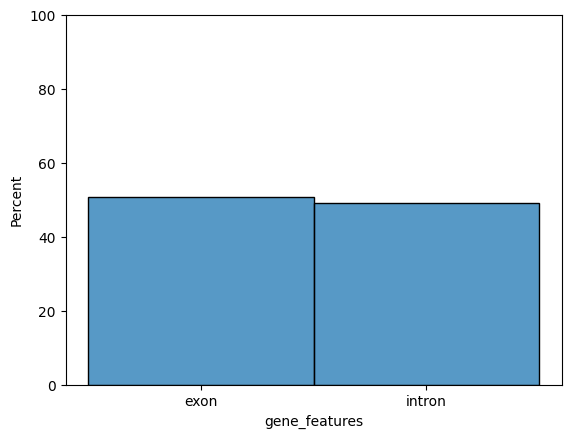

In [131]:
colors = ["#fdae61", "#4575b4"]
seaborn.histplot(exon_ov["gene_feature"], fill=["#009E73", "#F0E442"], stat = "percent")
plt.ylim(0, 100)

Similarly, it is possible to categorize peaks into promoter, gene body, etc. groups based on distance and upstream/downstream thresholds using bioframe. Promoter region peaks are filtered here using a maximum threshold of 2000kb upstream from promoter region.

In [132]:
out = bioframe.closest(
    genes,
    ctcf_peak,
    cols1=["seq_name", "gene_seq_start", "gene_seq_end"],
    ignore_overlaps=False,
    ignore_downstream=False,
    k=1,
)
#out[out["distance"] < 2000] #filter for peaks 2000kb upstream or closer to promoter region
out

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,...,start_,end_,name_,score_,strand_,fc_,-log10p_,-log10q_,relSummit_,distance
0,ENSG00000000457,SCYL3,protein_coding,169849631,169894267,chr1,-1,chromosome,SCY1 like pseudokinase 3 [Source:HGNC Symbol;A...,ENSG00000000457.14,...,169928909,169929405,.,1000.0,.,60.65136,-1.0,4.96085,248.0,34642
1,ENSG00000000460,C1orf112,protein_coding,169662007,169854080,chr1,1,chromosome,chromosome 1 open reading frame 112 [Source:HG...,ENSG00000000460.17,...,169809696,169809911,.,1000.0,.,88.64365,-1.0,4.96085,98.0,0
2,ENSG00000000938,FGR,protein_coding,27612064,27635185,chr1,-1,chromosome,"FGR proto-oncogene, Src family tyrosine kinase...",ENSG00000000938.13,...,27617083,27617579,.,169.0,.,16.03962,-1.0,4.01436,248.0,0
3,ENSG00000000971,CFH,protein_coding,196651754,196752476,chr1,1,chromosome,complement factor H [Source:HGNC Symbol;Acc:HG...,ENSG00000000971.17,...,196732584,196732793,.,1000.0,.,75.08894,-1.0,4.96085,93.0,0
4,ENSG00000001460,STPG1,protein_coding,24356999,24416934,chr1,-1,chromosome,sperm tail PG-rich repeat containing 1 [Source...,ENSG00000001460.18,...,24390112,24390362,.,1000.0,.,102.26210,-1.0,4.96085,119.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,ENSG00000242389,RBMY1E,protein_coding,21903618,21918042,chrY,-1,chromosome,RNA binding motif protein Y-linked family 1 me...,ENSG00000242389.9,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
20008,ENSG00000242875,RBMY1B,protein_coding,21511338,21525786,chrY,1,chromosome,RNA binding motif protein Y-linked family 1 me...,ENSG00000242875.7,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
20009,ENSG00000244395,RBMY1D,protein_coding,21880076,21894526,chrY,-1,chromosome,RNA binding motif protein Y-linked family 1 me...,ENSG00000244395.6,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
20010,ENSG00000258992,TSPY1,protein_coding,9466955,9469749,chrY,1,chromosome,testis specific protein Y-linked 1 [Source:HGN...,ENSG00000258992.7,...,<NA>,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
